# Actual Results
## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
import statsmodels.api as stm

from statsmodels.tsa.ar_model import AutoReg
from io import StringIO

import os

## Load data

In [2]:
weather_data = pd.DataFrame()

for file in os.listdir("weather-data"):
    with open(f"weather-data/{file}") as f:
        data = f.read()
        data = data[data.find("#")+1:] # Only read 
        curr_data = pd.read_csv(StringIO(data), low_memory=False)
        weather_data = pd.concat([weather_data, curr_data])
    
weather_data.columns = weather_data.columns.str.strip()
weather_data: pd.DataFrame = weather_data.apply(pd.to_numeric, errors='coerce')
date = pd.to_datetime(weather_data["YYYYMMDD"].astype(str) + (weather_data["HH"] - 1).astype(str).str.zfill(2), format="%Y%m%d%H", errors='coerce')
weather_data = pd.concat([date, weather_data], axis=1)
weather_data.rename({0: "date"}, axis=1, inplace=True)
weather_data.loc[:, "RH-fix"] = weather_data["RH"].replace({-1: 0}) / 10
weather_data.set_index(["date", "STN"], inplace=True)
weather_data.to_hdf("weather_data.hdf5", "measured_data")
weather_data

,,YYYYMMDD,HH,DD,FH,FF,FX,T,T10N,TD,SQ,...,N,U,WW,IX,M,R,S,O,Y,RH-fix
date,STN,,,,,,,,,,,,,,,,,,,,,
1971-01-01 00:00:00,240,19710101,1,140,15.0,10,26.0,-87,NaN,-95.0,NaN,...,9.0,93.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 01:00:00,240,19710101,2,130,10.0,10,26.0,-80,NaN,-87.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 02:00:00,240,19710101,3,190,10.0,10,21.0,-73,NaN,-80.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 03:00:00,240,19710101,4,210,10.0,10,21.0,-77,NaN,-84.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
1971-01-01 04:00:00,240,19710101,5,190,15.0,15,21.0,-84,NaN,-91.0,NaN,...,9.0,94.0,49.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 19:00:00,260,20201231,20,220,10.0,10,20.0,14,NaN,10.0,0.0,...,8.0,96.0,10.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 20:00:00,260,20201231,21,290,10.0,10,20.0,6,NaN,4.0,0.0,...,1.0,98.0,34.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0
2020-12-31 21:00:00,260,20201231,22,200,10.0,10,20.0,-10,NaN,-13.0,0.0,...,3.0,98.0,35.0,7.0,1.0,0.0,0.0,0.0,1.0,0.0


## Average rain per day

<AxesSubplot:title={'center':'Average rainfall per hour'}, xlabel='month', ylabel='average rain per hour (mm)'>

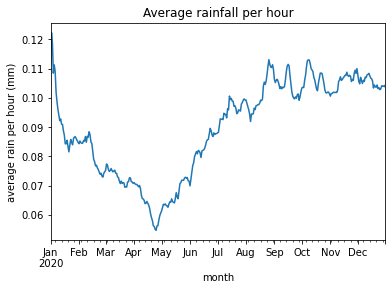

In [3]:
day_rainfall = weather_data.groupby([weather_data.index.get_level_values(0).month, weather_data.index.get_level_values(0).day]).mean()["RH-fix"]
day_rainfall.index = pd.to_datetime("2020" + day_rainfall.index.get_level_values(0).astype(int).astype(str).str.zfill(2) + day_rainfall.index.get_level_values(1).astype(int).astype(str).str.zfill(2), format="%Y%m%d")
day_rainfall.ewm(14).mean().plot(xlabel="month", ylabel="average rain per hour (mm)", title="Average rainfall per hour")

In [4]:
day_rainfall.ewm(14).mean().to_frame("rm").to_hdf("historical_daily_rainfall.hdf5", "rm")

## Rain per hour

<AxesSubplot:title={'center':'Average rain'}, xlabel='hour', ylabel='average rain per hour (mm)'>

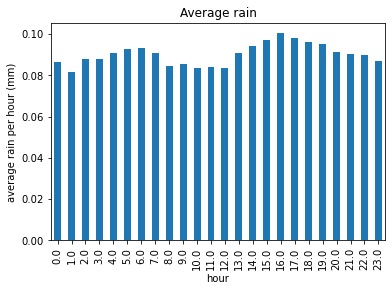

In [5]:
weather_data.groupby(weather_data.index.get_level_values(0).hour).mean()["RH-fix"].plot.bar(xlabel="hour", ylabel="average rain per hour (mm)", title="Average rain")

## Rain per station

STN
240    0.091861
260    0.093606
310    0.084906
Name: RH-fix, dtype: float64

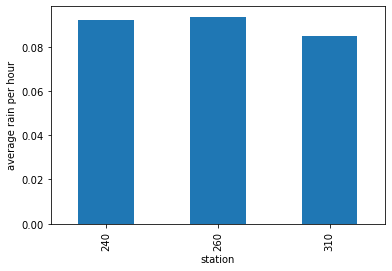

In [6]:
weather_data.groupby("STN").mean()["RH-fix"].plot.bar(xlabel="station", ylabel="average rain per hour")
weather_data.groupby("STN").mean()["RH-fix"]

STN
240    0.473202
260    0.489791
310    0.459209
Name: RH-fix, dtype: float64

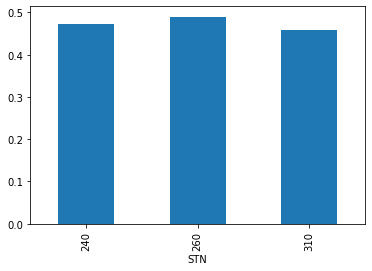

In [7]:
weather_data.groupby("STN").std()["RH-fix"].plot.bar()
weather_data.groupby("STN").std()["RH-fix"]

## Correlation between rain per station

In [8]:
print("Hourly:")
display(weather_data["RH-fix"].unstack().dropna().corr())
print("Daily:")
display(weather_data["RH-fix"].unstack().dropna().resample("D").sum().corr())
print("Weekly:")
display(weather_data["RH-fix"].unstack().dropna().resample("W").sum().corr())
print("Monthly:")
display(weather_data["RH-fix"].unstack().dropna().resample("M").sum().corr())
print("Yearly:")
display(weather_data["RH-fix"].unstack().dropna().resample("Y").sum().corr())

Hourly:


STN,240,260,310
STN,,,
240,1.000000,0.393208,0.197770
260,0.393208,1.000000,0.171562
310,0.197770,0.171562,1.000000


Daily:


STN,240,260,310
STN,,,
240,1.000000,0.766211,0.585251
260,0.766211,1.000000,0.581210
310,0.585251,0.581210,1.000000


Weekly:


STN,240,260,310
STN,,,
240,1.000000,0.851516,0.738255
260,0.851516,1.000000,0.724988
310,0.738255,0.724988,1.000000


Monthly:


STN,240,260,310
STN,,,
240,1.000000,0.882930,0.820037
260,0.882930,1.000000,0.790147
310,0.820037,0.790147,1.000000


Yearly:


STN,240,260,310
STN,,,
240,1.000000,0.924814,0.863636
260,0.924814,1.000000,0.883711
310,0.863636,0.883711,1.000000


## Probability of rain per hour per day

<AxesSubplot:xlabel='month', ylabel='average probability of rain of any given hour'>

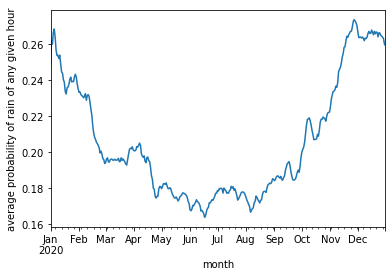

In [9]:
day_rainfall = weather_data.groupby([weather_data.index.get_level_values(0).month, weather_data.index.get_level_values(0).day]).mean()["R"]
day_rainfall.index = pd.to_datetime("2020" + day_rainfall.index.get_level_values(0).astype(int).astype(str).str.zfill(2) + day_rainfall.index.get_level_values(1).astype(int).astype(str).str.zfill(2), format="%Y%m%d")
day_rainfall.ewm(14).mean().plot(xlabel="month", ylabel="average probability of rain of any given hour")

In [10]:
day_rainfall.ewm(14).mean().to_frame("rp").to_hdf("historical_daily_rainfall.hdf5", "rp")

## Probability of rain per hour

<AxesSubplot:xlabel='hour', ylabel='probability of rain'>

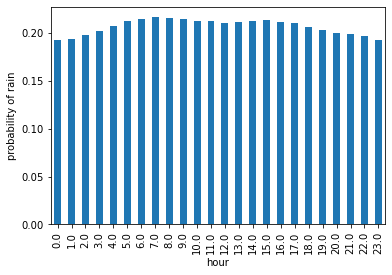

In [11]:
weather_data.groupby(weather_data.index.get_level_values(0).hour).mean()["R"].plot.bar(xlabel="hour", ylabel="probability of rain")

## If it rains, how much does it rain?

<AxesSubplot:xlabel='month', ylabel='rain per hour (mm)'>

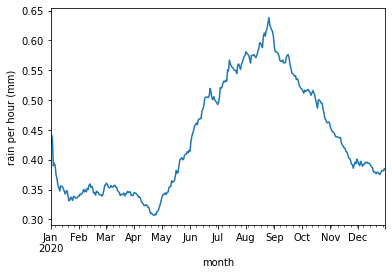

In [12]:
rain_if_falling = weather_data[weather_data["R"] == 1]["RH-fix"]

day_rainfall = rain_if_falling.groupby([rain_if_falling.index.get_level_values(0).month, rain_if_falling.index.get_level_values(0).day]).mean()
day_rainfall.index = pd.to_datetime("2020" + day_rainfall.index.get_level_values(0).astype(int).astype(str).str.zfill(2) + day_rainfall.index.get_level_values(1).astype(int).astype(str).str.zfill(2), format="%Y%m%d")
day_rainfall.ewm(14).mean().plot(xlabel="month", ylabel="rain per hour (mm)")

In [13]:
day_rainfall.ewm(14).mean().to_frame("rph").to_hdf("historical_daily_rainfall.hdf5", "rif")

## Rain over the years
Can we see an increase or decrease in rainfall over the years?

date
1951-01-31    86.300000
1951-02-28    64.800000
1951-03-31    88.800000
1951-04-30    79.000000
1951-05-31    47.900000
                ...    
2022-02-28    99.400000
2022-03-31    15.300000
2022-04-30    44.833333
2022-05-31    52.933333
2022-06-30    34.533333
Length: 858, dtype: float64

/Users/micha/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  858
Model:               Seas. AutoReg(0)   Log Likelihood               -4217.865
Method:               Conditional MLE   S.D. of innovations             33.016
Date:                Tue, 21 Jun 2022   AIC                           8463.731
Time:                        16:32:57   BIC                           8530.295
Sample:                    01-31-1951   HQIC                          8489.217
                         - 06-30-2022                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
trend          0.0070      0.004      1.557      0.119      -0.002       0.016
s(1,12)       62.1513      3.902     15.929      0.000      54.504      69.798
s(2,12)       48.4740      3.709     13.068      0.000      41.204      55.744
s(3,12)       49.1739      3.414     14.404      0.000      42.483      55.865
s(4,12)       39.9596      3.278     12.190      0.000      33.535      46.384
s(5,12)       49.6320      3.605     13.767      0.000      42.566      56.698
s(6,12)       61.0602      3.965     15.402      0.000      53.290      68.831
s(7,12)       72.9169      4.861     15.001      0.000      63.390      82.444
s(8,12)       78.4728      5.459     14.374      0.000      67.773      89.173
s(9,12)       68.7884      5.156     13.340      0.000      58.682      78.895
s(10,12)      74.8519      5.035     14.866      0.000      64.983      84.721
s(11,12)      74.3454      4.391     16.932      0.000      65.740      82.951
s(12,12)      73.1375      4.566     16.017      0.000      64.188      82.087
==============================================================================
"""

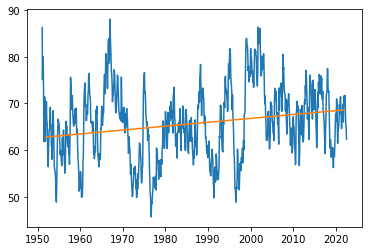

In [14]:
rain_per_month = weather_data["RH-fix"].unstack().mean(axis=1).resample("M").sum()
display(rain_per_month)
time_series_reg = AutoReg(rain_per_month, lags=0, seasonal=True, trend="t").fit(cov_type="HC0")
display(time_series_reg.summary())

plt.plot(rain_per_month.ewm(12).mean())
plt.plot(time_series_reg.predict(start=rain_per_month.index[0], end=rain_per_month.index[-1]).resample("Y").mean()[:-1])
plt.show()

Thus in a AR(1) model (with dummies for months), we can see that a trends exists (though it is insignificant).